In [1]:
##import libraries
import pandas as pd
import numpy as np
import os
import glob
from functools import reduce
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import ast
import plotly.express as px

In [2]:
##read data
drug_data = pd.read_csv( "/content/drive/MyDrive/Ten_years_data_cleand.csv")

drug_data.head()

,primaryid,caseid,caseversion,i_f_code,mfr_dt,init_fda_dt,fda_dt,rept_cod,mfr_num,mfr_sndr,...,route,dose_vbm,dechal,lot_num,nda_num,dose_form,indi_drug_seq,indi_pt,dsg_drug_seq,age_in_yrs
0,1314962521,13149625,21,F,2020-02-18,2017-01-25,2020-03-02,EXP,CA-CELLTRION INC.-2017CA000780,CELLTRION,...,Unknown,"UNK, 1X/DAY",U,UNKNOWN,206321.0,Unknown,Unknown,Unknown,17.0,NaN
1,1352573513,13525735,13,F,2019-12-23,2017-05-09,2020-01-06,EXP,CA-ROCHE-1931885,ROCHE,...,Unknown,UNK,U,UNKNOWN,206321.0,Unknown,21.0,Product used for unknown indication,Unknown,44.0
2,147306292,14730629,2,F,2020-02-27,2018-04-06,2020-03-09,EXP,GB-NOVOPROD-593576,NOVO NORDISK,...,Subcutaneous,1.8 MG,U,UNKNOWN,22341.0,SOLUTION FOR INJECTION,1.0,Diabetes mellitus,1.0,63.0
3,151265324,15126532,4,F,2020-01-02,2018-07-10,2020-01-07,EXP,US-JNJFOC-20180709795,JOHNSON AND JOHNSON,...,Unknown,UNK,D,UNKNOWN,206321.0,Unknown,4.0,Product used for unknown indication,Unknown,70.0
4,152211425,15221142,5,F,2020-01-22,2018-07-31,2020-01-30,EXP,PT-AUROBINDO-AUR-APL-2018-038679,AUROBINDO,...,Oral,"100 MILLIGRAM, ONCE A DAY",Y,UNKNOWN,206321.0,CAPSULE,17.0,Weight decreased,Unknown,48.0


**Adverse Events Frequency Counts**

In [3]:
##frequency count of AEs
pt_series = drug_data['pt'].dropna()
pt_series = pt_series[pt_series.map(lambda x: len(x) > 0)]  # filter out empty lists

# Flatten and count
reaction_counts = Counter(
    reaction.strip()
    for reactions in pt_series
    for reaction in ast.literal_eval(reactions)
)

##Display AE counts
reaction_df = pd.DataFrame.from_dict(reaction_counts, orient='index', columns=['count']).reset_index()
reaction_df.columns = ['reaction', 'count']
print(reaction_df.sort_values(by='count', ascending=False))

                             reaction  count
116                  Drug ineffective   3277
18                             Nausea   2293
63                          Diarrhoea   1448
25                           Vomiting   1333
8                    Weight increased    945
...                               ...    ...
2813           Small fibre neuropathy      1
2810              Colitis microscopic      1
2808        Blood magnesium decreased      1
2770  Exposure to extreme temperature      1
2773                  Foot amputation      1

[2838 rows x 2 columns]


In [5]:
##top 20 most common adverse events
top_20 = reaction_counts.most_common(20)
top_20_df = pd.DataFrame(top_20, columns = ['adverse_event', 'count'])


print(top_20_df)

              adverse_event  count
0          Drug ineffective   3277
1                    Nausea   2293
2                 Diarrhoea   1448
3                  Vomiting   1333
4          Weight increased    945
5                  Headache    878
6             Off label use    850
7              Constipation    839
8                   Fatigue    796
9              Steatorrhoea    782
10     Abdominal pain upper    714
11    Product quality issue    655
12                 Dyspnoea    620
13  Treatment noncompliance    617
14           Abdominal pain    579
15                  Anxiety    554
16                  Malaise    547
17         Weight loss poor    521
18         Rectal discharge    501
19                Dizziness    492


/tmp/ipython-input-2540412414.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_df, x='count', y='adverse_event', palette='viridis')


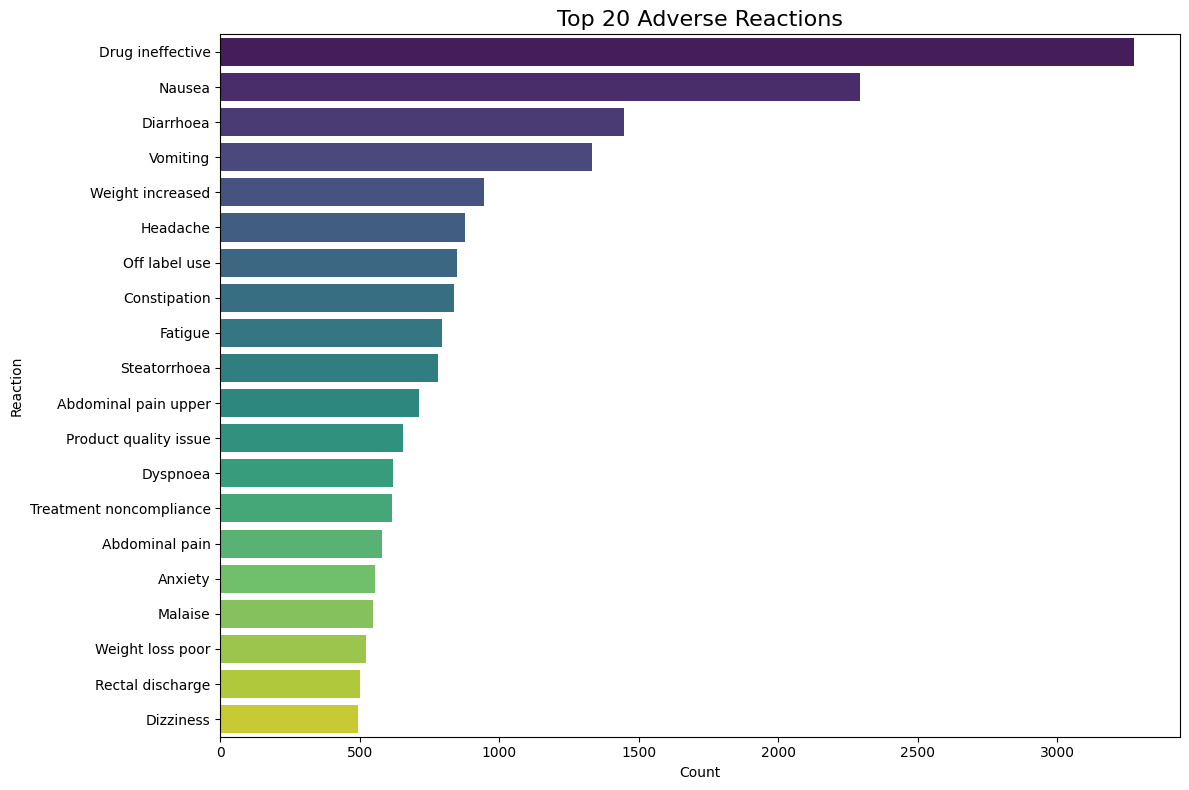

In [7]:
# Ensure plot is in notebook (if using Jupyter)
%matplotlib inline

##set fig size
plt.figure(figsize=(12, 8))

##bar plot
sns.barplot(data=top_20_df, x='count', y='adverse_event', palette='viridis')

##labels
plt.title('Top 20 Adverse Reactions', fontsize=16)
plt.xlabel('Count')
plt.ylabel('Reaction')
plt.tight_layout()

##show plot
plt.show()

In [8]:
##top 5 counts and percentages of AEs per drug

#copy drug data
df = drug_data.copy()

# Convert stringified lists to actual lists
df['pt'] = df['pt'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# Convert to uppercase to ensure uniformity
df['drugname'] = df['drugname'].str.upper()
df['pt'] = df['pt'].apply(lambda x: [i.upper() for i in x])

# Explode the pt column to get one AE per row
df_exploded = df.explode('pt')

# Drop rows with missing data
df_exploded = df_exploded.dropna(subset=['drugname', 'pt'])

# Count AEs per drug
ae_counts = df_exploded.groupby(['drugname', 'pt']).size().reset_index(name='count')

# Total AE reports per drug
total_counts = ae_counts.groupby('drugname')['count'].sum().reset_index(name='total_count')

# Merge and calculate percentage
ae_counts = ae_counts.merge(total_counts, on='drugname')
ae_counts['percentage'] = (ae_counts['count'] / ae_counts['total_count']) * 100

# Get top N AEs per drug
top_n = 5
ae_top_n = ae_counts.sort_values(['drugname', 'count'], ascending=[True, False])
ae_top_n = ae_top_n.groupby('drugname').head(top_n)

# Show results
print(ae_top_n)

         drugname                       pt  count  total_count  percentage
174          ALLI         DRUG INEFFECTIVE   2407        12980   18.543914
628          ALLI             STEATORRHOEA    733        12980    5.647149
671          ALLI  TREATMENT NONCOMPLIANCE    595        12980    4.583975
550          ALLI    PRODUCT QUALITY ISSUE    536        12980    4.129430
572          ALLI         RECTAL DISCHARGE    496        12980    3.821263
1104  LIRAGLUTIDE                 DYSPNOEA    395        20094    1.965761
787   LIRAGLUTIDE                  ANXIETY    321        20094    1.597492
983   LIRAGLUTIDE     CONDITION AGGRAVATED    293        20094    1.458147
813   LIRAGLUTIDE                   ASTHMA    281        20094    1.398427
2136  LIRAGLUTIDE                 WHEEZING    280        20094    1.393451
2759     ORLISTAT                 VOMITING     39         2345    1.663113
2539     ORLISTAT                   NAUSEA     36         2345    1.535181
2564     ORLISTAT        

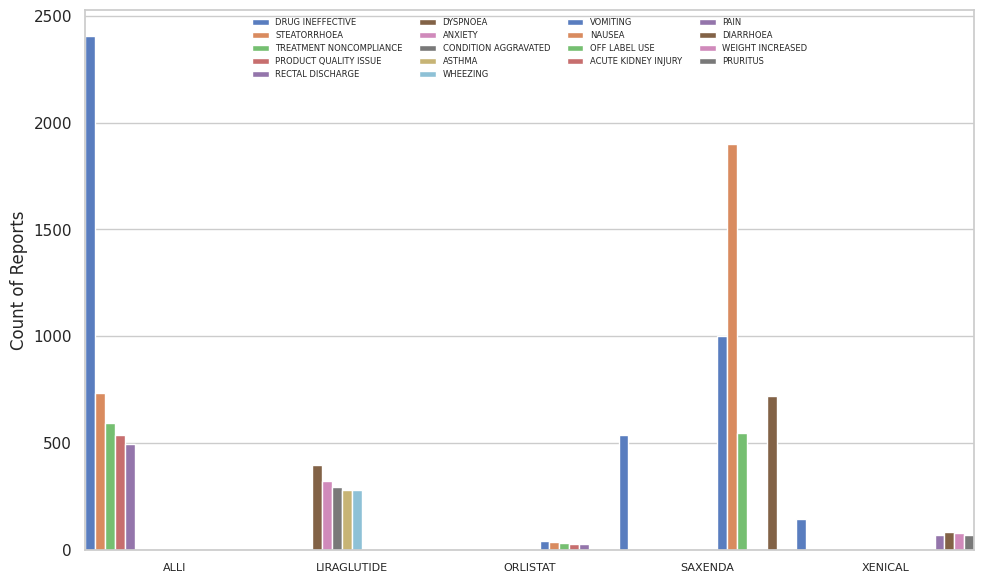

In [9]:
##barplot for the top 5 AEs per drug

# Set a modern style
sns.set(style='whitegrid', palette='muted')

# Create the figure
plt.figure(figsize=(10, 6))

# Use a visually appealing color palette
palette = sns.color_palette("tab10", n_colors=ae_top_n['pt'].nunique())

# Barplot with improved styling
sns.barplot(
    data=ae_top_n,
    x='drugname',
    y='count',
    hue='pt',
    palette='muted',
    width = 1
)

# Customize axes and title
plt.xlabel("", fontsize=10)
plt.ylabel("Count of Reports", fontsize=12)
#plt.title("Top Adverse Events by Drug", fontsize=14)

# Rotate x-axis labels
plt.xticks(fontsize=8)

# Legend styling
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.0),
    ncol=4,  # Adjust based on how many PTs you have
    frameon=False,
    fontsize=6,
    title_fontsize=11
)

plt.tight_layout()
plt.show()

In [11]:
##number of death outcomes per drug

#Parse the stringified lists
df = drug_data.copy()
#Convert to uppercase to ensure uniformity
df['drugname'] = df['drugname'].str.upper()

def safe_parse(x):
    if isinstance(x, list):
        return x
    if pd.isnull(x):
        return []
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return [x] if isinstance(x, str) else []

#df['outcomes_list'] = df['outc_cod'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])
df['outcomes_list'] = df['outc_cod'].apply(safe_parse)

#Explode outcomes into separate rows
df_exploded = df.explode('outcomes_list')

#Group by drug and outcome, count and calculate percentage
summary = (
    df_exploded
    .groupby(['drugname', 'outcomes_list'])
    .size()
    .reset_index(name='count')
)

summary['percentage'] = (
    summary
    .groupby('drugname')['count']
    .transform(lambda x: 100 * x / x.sum())
)

#Round for readability
summary['percentage'] = summary['percentage'].round(2)

#Sort for clarity
summary = summary.sort_values(['drugname', 'count'], ascending=[True, False])

#Display the result
print(summary)

       drugname outcomes_list  count  percentage
5          ALLI        Unkown   5498       91.13
4          ALLI            OT    360        5.97
2          ALLI            HO     98        1.62
1          ALLI            DS     56        0.93
3          ALLI            LT     16        0.27
0          ALLI            DE      5        0.08
11  LIRAGLUTIDE            OT   1746       43.18
9   LIRAGLUTIDE            HO   1379       34.10
10  LIRAGLUTIDE            LT    536       13.25
7   LIRAGLUTIDE            DE    236        5.84
12  LIRAGLUTIDE        Unkown    105        2.60
8   LIRAGLUTIDE            DS     36        0.89
6   LIRAGLUTIDE            CA      6        0.15
18     ORLISTAT            OT    338       61.79
16     ORLISTAT            HO    121       22.12
19     ORLISTAT        Unkown     28        5.12
17     ORLISTAT            LT     23        4.20
15     ORLISTAT            DS     20        3.66
14     ORLISTAT            DE     11        2.01
13     ORLISTAT     

/tmp/ipython-input-4081358815.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=death_df, x='drugname', y='count', palette='Reds')


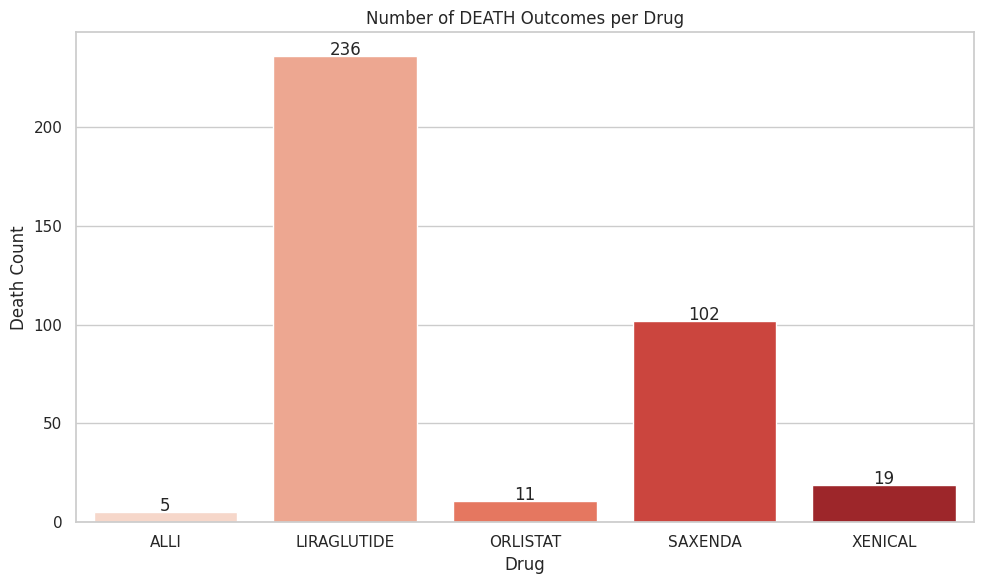

In [12]:
##show bar plots

#Filter for DEATH outcome
death_df = summary[summary['outcomes_list'] == 'DE']

#Plot bar chart
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=death_df, x='drugname', y='count', palette='Reds')

#Add labels on bars
for i, row in death_df.iterrows():
    barplot.text(
        x=death_df.index.get_loc(i),
        y=row['count'] + 0.5,
        s=int(row['count']),
        ha='center'
    )

#Final touches
plt.title("Number of DEATH Outcomes per Drug")
plt.ylabel("Death Count")
plt.xlabel("Drug")
plt.tight_layout()
plt.show()

/tmp/ipython-input-139715162.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=death_df, x='drugname', y='count', palette='Reds')


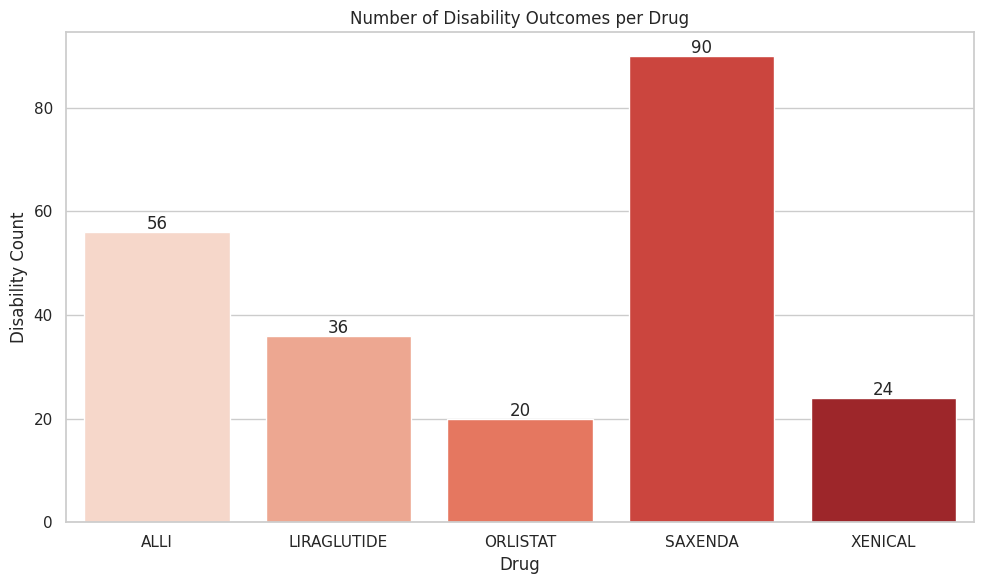

In [13]:
##number of disability outcomes per drug

#Filter for Disability outcome
death_df = summary[summary['outcomes_list'] == 'DS']

#Plot bar chart
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=death_df, x='drugname', y='count', palette='Reds')

#Add labels on bars
for i, row in death_df.iterrows():
    barplot.text(
        x=death_df.index.get_loc(i),
        y=row['count'] + 0.5,
        s=int(row['count']),
        ha='center'
    )

#Final touches
plt.title("Number of Disability Outcomes per Drug")
plt.ylabel("Disability Count")
plt.xlabel("Drug")
plt.tight_layout()
plt.show()

**Temporal Trends Analysis**

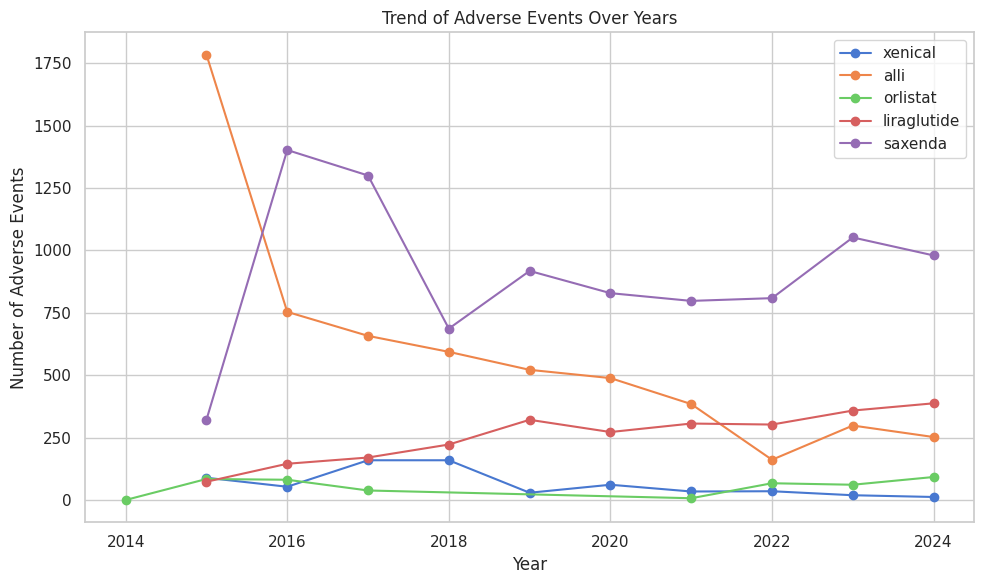

In [14]:
##adverse event reports over years for each drug

#target drug list
target_drugs = ['xenical', 'alli', 'orlistat', 'liraglutide', 'saxenda']

##copy drug data
df = drug_data.copy()

# Convert date column to datetime if needed
df['fda_dt'] = pd.to_datetime(df['fda_dt'], errors='coerce')

# Extract year
df['year'] = df['fda_dt'].dt.year

# Filter for target drugs only
filtered_df = df[df['drugname'].str.lower().isin(target_drugs)]

filtered_df['drugname'] = filtered_df['drugname'].str.lower()

# Group by drug and year, count the adverse events
trend_data = filtered_df.groupby(['drugname', 'year']).size().reset_index(name='count')

# Plot
plt.figure(figsize=(10, 6))
for drug in target_drugs:
    subset = trend_data[trend_data['drugname'].str.lower() == drug]
    plt.plot(subset['year'], subset['count'], marker='o', label=drug)

plt.xlabel('Year')
plt.ylabel('Number of Adverse Events')
plt.title('Trend of Adverse Events Over Years')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

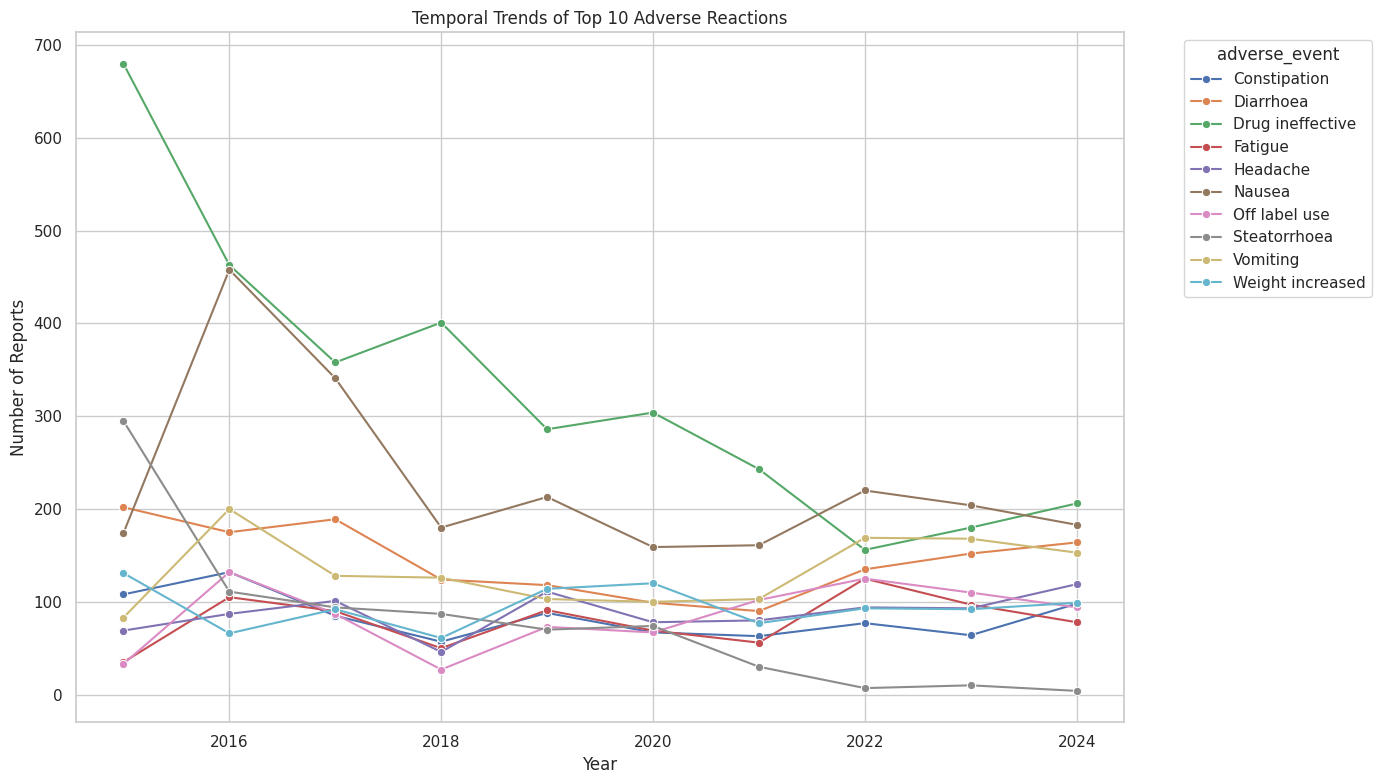

In [20]:
## Temporal trends of the top 10 AEs

df = drug_data.copy()
# Clean and convert pt column
df['pt'] = df['pt'].fillna("[]").astype(str)

# Strip brackets, then split into lists
df['adverse_event'] = (
    df['pt']
    .str.strip('[]')
    .str.replace("'", "")
    .str.replace('"', '')
    .str.split(',')
)

# Explode the pt_cleaned list into rows
df_exploded = df.explode('adverse_event')

# Clean extra whitespace and drop empty strings
df_exploded['adverse_event'] = df_exploded['adverse_event'].str.strip()
df_exploded = df_exploded[df_exploded['adverse_event'] != '']

## convert to datetime
df_exploded['fda_dt'] = pd.to_datetime(df_exploded['fda_dt'], errors = 'coerce')

## extract the year from the date column
df_exploded['fda_dt'] = df_exploded['fda_dt'].dt.year

# Ensure year is numeric
#df_exploded['fda_dt'] = pd.to_numeric(df_exploded['fda_dt'], errors='coerce')

# Get top 10 adverse reactions overall
top_10 = (
    df_exploded['adverse_event']
    .value_counts()
    .head(10)
    .index
    .tolist()
)

# Filter to top reactions and group by year
top_df = df_exploded[df_exploded['adverse_event'].isin(top_10)]
trend_df = (
    top_df.groupby(['fda_dt', 'adverse_event'])
    .size()
    .reset_index(name='count')
)

# Plot
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=trend_df,
    x='fda_dt',
    y='count',
    hue='adverse_event',
    marker='o',
    errorbar = None
)
plt.title('Temporal Trends of Top 10 Adverse Reactions')
plt.xlabel('Year')
plt.ylabel('Number of Reports')
plt.legend(title='adverse_event', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

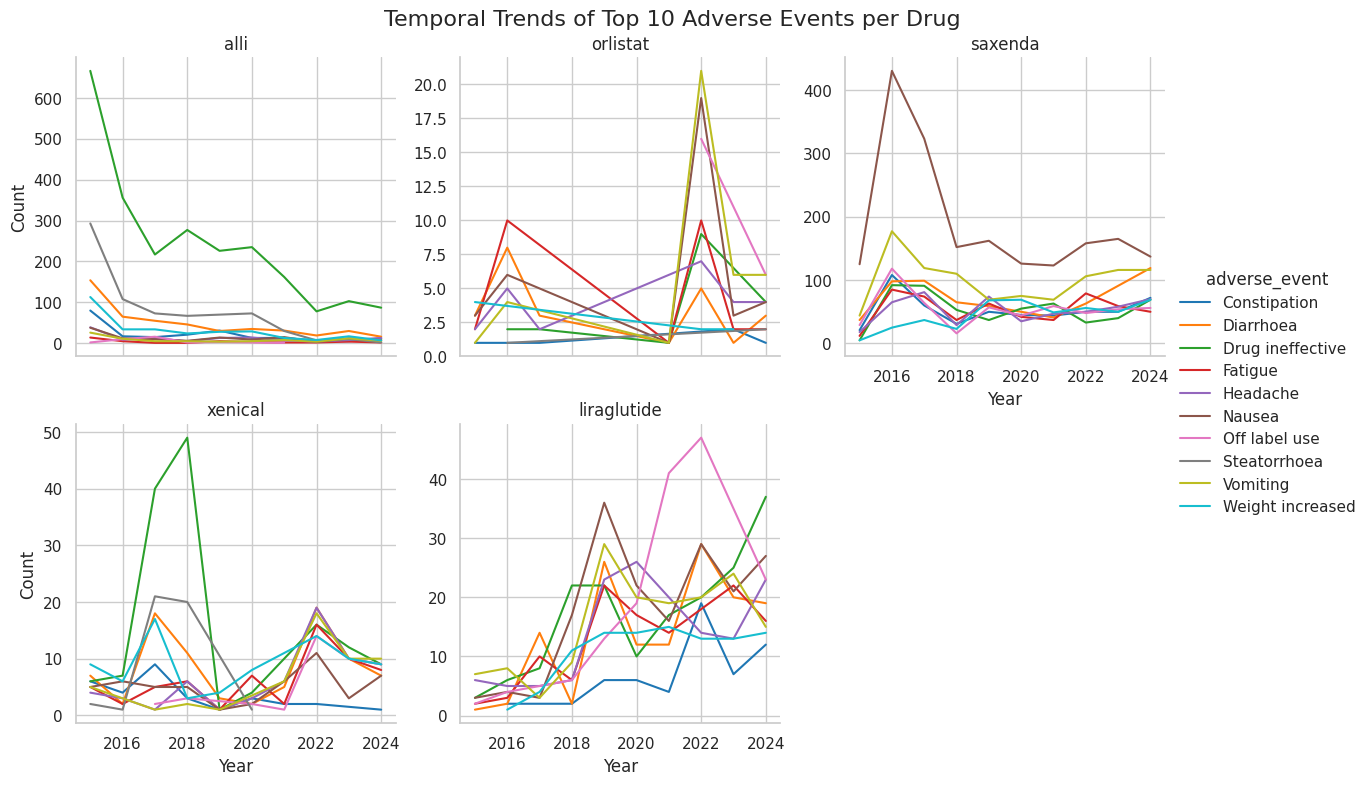

In [21]:
##temporal trends of the top AEs per drug

##normalize drugname
df_exploded['drugname'] = df_exploded['drugname'].str.lower()

# Group by fda_dt, pt_cleaned, and drugname
trend_df = (
    df_exploded.groupby(['fda_dt', 'adverse_event', 'drugname'])
    .size()
    .reset_index(name='count')
)

# Filter to only include top 10 reactions
top_10_reactions = trend_df.groupby('adverse_event')['count'].sum().nlargest(10).index
trend_df_top = trend_df[trend_df['adverse_event'].isin(top_10_reactions)]
# Set the theme
sns.set_theme(style="whitegrid")

# Plot using FacetGrid: One plot per drug
g = sns.FacetGrid(
    trend_df_top,
    col='drugname',
    hue='adverse_event',
    col_wrap=3,
    height=4,
    sharey=False,
    palette='tab10',
)

g.map_dataframe(sns.lineplot,
                'fda_dt',
                'count',
               errorbar = None)
g.add_legend()
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Year", "Count")
plt.subplots_adjust(top=0.92)
g.fig.suptitle("Temporal Trends of Top 10 Adverse Events per Drug", fontsize=16)
plt.show()

In [22]:
##interactive plot with plotly

fig = px.line(
    trend_df_top,
    x="fda_dt",
    y="count",
    color="adverse_event",
    line_group="drugname",
    facet_col="drugname",
    facet_col_wrap=3,
    title="Temporal Trends of Adverse Events by Drug (Interactive)",
    labels={"adverse_event": "Adverse Event", "fda_dt": "Year", "count": "Reported Count"},
    markers=True
)

fig.update_layout(height=800, legend_title_text='Adverse Event')
fig.show()